In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from qiskit_nature.second_q.drivers import PySCFDriver

# Create molecule
driver = PySCFDriver(atom='H 0 0 0; H 0 0 0.735', basis='sto3g')

In [3]:
# Get second quantized Hamiltonian
problem = driver.run()
hamiltonian = problem.hamiltonian.second_q_op()
print(hamiltonian)

Fermionic Operator
number spin orbitals=4, number terms=36
  -1.25633907300325 * ( +_0 -_0 )
+ -0.47189600728114184 * ( +_1 -_1 )
+ -1.25633907300325 * ( +_2 -_2 )
+ -0.47189600728114184 * ( +_3 -_3 )
+ 0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.3322908651276482 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.3322908651276482 * ( +_0 +_3 -_3 -_0 )
+ 0.09046559989211572 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211572 * ( +_0 +_1 -_0 -_1 )
+ 0.09046559989211572 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211572 * ( +_0 +_3 -_2 -_1 )
+ 0.09046559989211572 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211572 * ( +_1 +_1 -_0 -_0 )
+ 0.09046559989211572 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211572 * ( +_1 +_3 -_2 -_0 )
+ 0.3322908651276482 * ( +_1 +_0 -_0 -_1 )
+ 0.34928686136600884 * ( +_1 +_1 -_1 -_1 )
+ 0.3322908651276482 * ( +_1 +_2 -_2 -_1 )
+ 0.34928686136600884 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.3322908651276482 * ( +_2 +_1 -_1 -_2 )
+ 0.33785507

In [4]:
from qiskit_nature.second_q.mappers import JordanWignerMapper

# Map to qubit Hamiltonian

qubit_mapper = JordanWignerMapper()
qubit_hamiltonian = qubit_mapper.map(hamiltonian)
print(qubit_hamiltonian)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.81054798+0.j,  0.17218393+0.j, -0.22575349+0.j,  0.17218393+0.j,
 -0.22575349+0.j,  0.12091263+0.j,  0.16892754+0.j,  0.16614543+0.j,
  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,
  0.16614543+0.j,  0.17464343+0.j,  0.12091263+0.j])


In [5]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
exact_solver = NumPyMinimumEigensolver()
exact_job = exact_solver.compute_minimum_eigenvalue(qubit_hamiltonian)
exact_result = problem.interpret(exact_job)
print(exact_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 


In [6]:
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

# Setup ansatz
initial_state = HartreeFock(
    num_spatial_orbitals=problem.num_spatial_orbitals, 
    num_particles=problem.num_particles, 
    qubit_mapper=qubit_mapper)

ansatz = UCCSD(
    num_spatial_orbitals=problem.num_spatial_orbitals, 
    num_particles=problem.num_particles, 
    qubit_mapper=qubit_mapper, 
    initial_state=initial_state)

In [8]:
ansatz.decompose(reps=1).draw()

┌───┐┌───────────────────────────────┐┌───────────────────────────────┐»
q_0: ┤ X ├┤0                              ├┤0                              ├»
     └───┘│                               ││                               │»
q_1: ─────┤1                              ├┤1                              ├»
     ┌───┐│  exp(-it (IIXY + IIYX))(t[0]) ││  exp(-it (XYII + YXII))(t[1]) │»
q_2: ┤ X ├┤2                              ├┤2                              ├»
     └───┘│                               ││                               │»
q_3: ─────┤3                              ├┤3                              ├»
          └───────────────────────────────┘└───────────────────────────────┘»
«     ┌─────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                        ├
«     │                                                                         │
«q_1: ┤1                                                                        ├
«     │  exp(-it (YYXY + XYYY + XXXY + YXYY + XYXX + YYYX + YXXX + XXYX))(t[2]) │
«q_2: ┤2                                                                        ├
«     │                                                                         │
«q_3: ┤3                                                                        ├
«     └─────────────────────────────────────────────────────────────────────────┘

In [9]:
from qiskit.algorithms.optimizers import COBYLA

from qiskit.algorithms.minimum_eigensolvers import VQE,  MinimumEigensolverResult
from qiskit.primitives import Estimator

# Setup optimizer
optimizer = COBYLA(maxiter=2500)

# Setup callback
energies = []
def callback(nfev, x, fx, *args):
    energies.append(fx)

# Setup VQE
estimator = Estimator()
vqe_solver = VQE(estimator, ansatz, optimizer, callback=callback)

In [10]:
# Solve for the groundstate
job = vqe_solver.compute_minimum_eigenvalue(qubit_hamiltonian)
result = problem.interpret(job)
print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275016169
  - computed part:      -1.857275016169
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.13730602172
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 


In [11]:
#store the vqe energies from callback in a list
vqe_energies = []

for energy in energies:
    result = MinimumEigensolverResult()
    result.eigenvalue = energy
    vqe_energies.append(problem.interpret(result).total_energies[0])

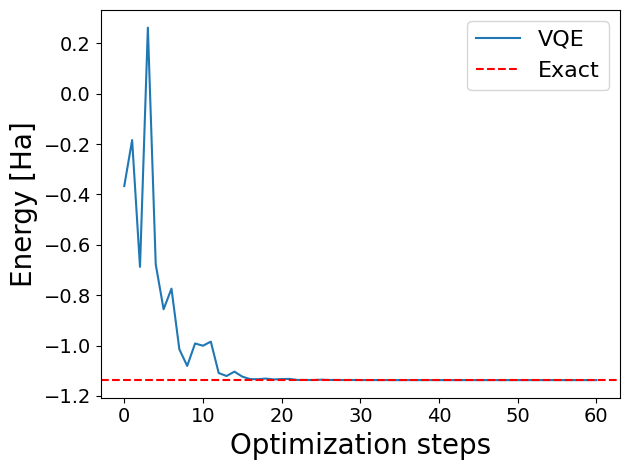

In [12]:
# Plot
plt.plot(vqe_energies, label='VQE')
plt.axhline(exact_result.total_energies[0], color='red', linestyle='dashed', label='Exact')

plt.ylabel('Energy [Ha]', fontsize=20)
plt.xlabel('Optimization steps', fontsize=20)

plt.tick_params(which='both', labelsize=14)
plt.legend(fontsize=16)
plt.tight_layout()

In [13]:
# Create LiH molecule
driver = PySCFDriver(atom='Li 0 0 0; H 0 0 1.5', basis='sto3g')

# Get second quantized Hamiltonian
problem = driver.run()
hamiltonian = problem.hamiltonian.second_q_op()

# Map to qubit Hamiltonian
qubit_mapper = JordanWignerMapper()
qubit_hamiltonian = qubit_mapper.map(hamiltonian)
print(qubit_hamiltonian.num_qubits)

12


In [14]:
# Activate space transformer
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

active_space_transformer = ActiveSpaceTransformer(num_electrons=2, num_spatial_orbitals=2)
as_problem = active_space_transformer.transform(problem)
as_hamiltonian = qubit_mapper.map(as_problem.hamiltonian.second_q_op())
print(as_hamiltonian.num_qubits)

4


In [15]:
# Activate space transformer with specific orbitals
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

active_space_transformer = ActiveSpaceTransformer(num_electrons=2, num_spatial_orbitals=2,active_orbitals=[0, 4])
as_problem = active_space_transformer.transform(problem)
as_hamiltonian = qubit_mapper.map(as_problem.hamiltonian.second_q_op())
print(as_hamiltonian.num_qubits)

4


In [16]:
print(as_problem.hamiltonian.constants)

{'nuclear_repulsion_energy': 1.05835442184, 'ActiveSpaceTransformer': -2.5698739591452}


In [17]:
# Create molecule
driver = PySCFDriver(atom='Li 0 0 0; H 0 0 1.5', basis='sto3g')

# Get second quantized Hamiltonian
problem = driver.run()
hamiltonian = problem.hamiltonian.second_q_op()

# Map to qubit Hamiltonian
qubit_mapper = JordanWignerMapper()
qubit_hamiltonian = qubit_mapper.map(hamiltonian)
print(qubit_hamiltonian.num_qubits)

12


In [18]:
from qiskit_nature.second_q.transformers import FreezeCoreTransformer

fc_transformer = FreezeCoreTransformer()

fc_problem = fc_transformer.transform(problem)
fc_hamiltonian = fc_problem.hamiltonian.second_q_op()
# Map to qubit Hamiltonian
qubit_mapper = JordanWignerMapper()
qubit_hamiltonian = qubit_mapper.map(fc_hamiltonian)
print(qubit_hamiltonian.num_qubits)

10


In [19]:
print(fc_problem.hamiltonian.constants)

{'nuclear_repulsion_energy': 1.05835442184, 'FreezeCoreTransformer': -7.840306048794257}


In [20]:
fc_transformer = FreezeCoreTransformer(remove_orbitals=[4, 5]) # specify the orbitals to be frozen

fc_problem = fc_transformer.transform(problem)
fc_hamiltonian = fc_problem.hamiltonian.second_q_op()
qubit_mapper = JordanWignerMapper()
qubit_hamiltonian = qubit_mapper.map(fc_hamiltonian)
print(qubit_hamiltonian.num_qubits)

6


In [21]:
driver = PySCFDriver(atom='H 0 0 0; H 0 0 0.735', basis='sto3g')
es_problem = driver.run()
hamiltonian = es_problem.hamiltonian
second_q_op = hamiltonian.second_q_op()
num_particles = es_problem.num_particles
num_spatial_orbitals = es_problem.num_spatial_orbitals
mapper = JordanWignerMapper()
qubit_op = mapper.map(second_q_op)
init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
ansatz = UCCSD(num_spatial_orbitals,num_particles, mapper, initial_state=init_state)

In [22]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()
service = QiskitRuntimeService(channel="ibm_quantum", instance='ibm-q/open/main') 
sim = service.get_backend('ibmq_qasm_simulator') # can be replaced with the device you want to use - example ibm_brisbane

In [23]:
options = Options()
options.execution.shots = 4000 ##number of shots
optimizer = COBYLA()

In [24]:
with Session(service=service, backend=sim):
    estimator = Estimator(options=options)
    vqe = VQE(estimator,ansatz,optimizer)
    result = vqe.compute_minimum_eigenvalue(qubit_op)
freeze_core = es_problem.hamiltonian.constants
energies = list(freeze_core.values())
gse = result.optimal_value + energies[0]

In [25]:
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 41,
    'eigenvalue': -1.848105524701775,
    'optimal_circuit': <qiskit_nature.second_q.circuit.library.ansatzes.uccsd.UCCSD object at 0x152f9d951690>,
    'optimal_parameters': {   ParameterVectorElement(t[0]): 6.30049162601967,
                              ParameterVectorElement(t[1]): -0.01818748485142203,
                              ParameterVectorElement(t[2]): 3.077454558642367},
    'optimal_point': array([ 6.30049163, -0.01818748,  3.07745456]),
    'optimal_value': -1.848105524701775,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x152f9d951ab0>,
    'optimizer_time': 192.16923356056213}


In [26]:
print(f"VQE Energy = {gse} Hartree")

VQE Energy = -1.1281365302527955 Hartree


In [27]:
import qiskit.tools.jupyter
%qiskit_version_table